# Image Segmentation
In this notebook, we'll examine a new application for Convolutional Neural Networks (CNNs) - image segmentation. This notebook will build on the classification example shown in the previous notebooks using CNNs.

**Learning Objectives**

1. Describe the U-net architecture for CNNs.
2. Implement a U-net in PyTorch for image segmentation.
3. Test various modifications for a U-net to improve the segmentation.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split

Let's prepare our device to use PyTorch:

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Motivation
In our previous examples with CNNs, we built a convolutional neural network for image classification. In other words, each image gave us one value in a given range. Here, we are going to explore how we can classify *each pixel* in an image.

In this notebook, we are going to take on the task of classifying pixels in satellite imagery to determine whether or not they represent clouds. This is a common task when using satellite data since clouds are often pesky features that obscure data on the surface of the Earth - removing them prior to calculations is an important part of a typical processing pipline.

Let's have a peek at some of the example data I've prepared:

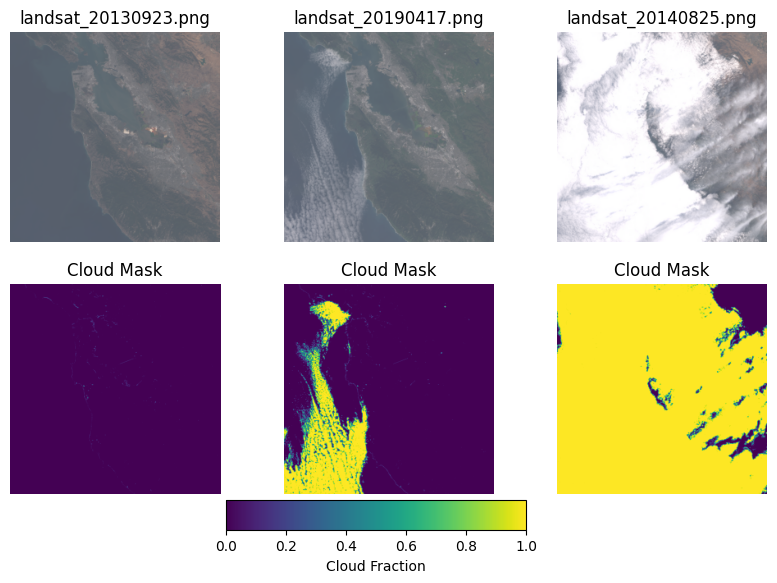

In [4]:
# define the locations of the demo images and the corresponding masks
demo_images_dir="Data/Demo/Images"
demo_masks_dir="Data/Demo/Masks"

# get the paths of the images
img_names = ['landsat_20130923.png','landsat_20190417.png','landsat_20140825.png']

fig = plt.figure(figsize=(10,6))

for i, img_name in enumerate(img_names):

    img_path = os.path.join(demo_images_dir, img_name)
    msk_path = os.path.join(demo_masks_dir, img_name[:-4]+'_cloud_mask.png')

    img = Image.open(img_path).convert("RGB")
    msk = Image.open(msk_path).convert("L")

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

    plt.subplot(2,3,i+4)
    C = plt.imshow(np.array(msk)/255,vmin=0,vmax=1)
    plt.title('Cloud Mask')
    plt.axis('off')

cax = fig.add_axes([0.35, 0.05, 0.3, 0.05])
fig.colorbar(C, cax=cax, orientation='horizontal', label='Cloud Fraction')

plt.show()

As we can see, there is a range of cloud coverage in these images and the cloud masks in the bottom row of the image give values for 1 when clouds are present and 0 when they are not present. Here, we will build a model to take in "visual" satellite images and return the cloud mask.

## The U-Net Architecture

The U-net architecture is a type of convolutional neural network that is designed for image segmentation tasks. The start of the network is similar to the netural network we investigated previously for image classification tasks. In that network, a series of convolutional and pooling layers reduced the width and height of the images. These layers are what we might call *down sampling* or *encoding*. In a U-net architecture, this process is reversed and there is an *up sampling* or *decoding* layer that recovers the image dimensions. In this example, we will take a look at a U-net with the following structure:

<img src="Unet_schematic.png" alt="Schematic of a Unet" width="800">

We can see from the scematic above why this architecture would be called a "U-net". It is a collection of convolutions that extract image features at a variety of scales.

Let's start to code this up here. To start, let's make a helper function called `double_conv` which will apply two sequential convolutional, batch normalization, and `ReLU` (non-linear) layers:

In [5]:
def double_conv(in_ch, out_ch, dilation=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=dilation,
                  dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=dilation,
                  dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

Next, let's construct a `Unet` class from the `nn.Module` class, following the structure in the image above.

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512], dilation=1):
        super().__init__()

        # make a max pooler
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Formulate the encoder
        self.downs = nn.ModuleList()
        ch_in = in_channels
        for feat in features:
            self.downs.append(double_conv(ch_in, feat))
            ch_in = feat

        # The "bottleneck" also a has a double convolutional layer
        self.bottleneck = double_conv(features[-1], 2 * features[-1], dilation=dilation)

        # Formulate the decoder
        self.ups = nn.ModuleList()
        ch_in = 2 * features[-1]
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(ch_in, feat, kernel_size=2, stride=2))
            self.ups.append(double_conv(ch_in, feat))
            ch_in = feat

        # make a final convolutional layer
        self.final_conv = nn.Conv2d(features[0], out_channels=1, kernel_size=1)

    def forward(self, x):

        # make a list for the skip connections
        skip_connections = []

        # make the downward U section
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # make the bottleneck
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        # make the upward U section
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skip_connections[i // 2]

            x = torch.cat([skip, x], dim=1)

            x = self.ups[i + 1](x)
        
        x = self.final_conv(x)
        return x        

In the code block above, we define an `init` function and a `forward` function in the same way we've done for the other PyTorch models we've created so far.

## Setting up the Training Loop

In order to train our model, we're going to need `DataLoader` objects for the training and the testing sets. We'll do this by designing a `SatelliteDataset` class that extends the `Dataset` class from PyTorch: 

In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_transform = None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_transform = img_transform

        # make a list of source files
        self.img_files = []
        self.msk_files = []
        for file_name in sorted(os.listdir(images_dir)):
            if file_name[0]!='.' and file_name.endswith('.png'):
                if file_name[:-4]+'_cloud_mask.png' in os.listdir(masks_dir):
                    self.img_files.append(file_name)
                    self.msk_files.append(file_name[:-4]+'_cloud_mask.png')

    # overwrite the len function
    def __len__(self):
        return len(self.img_files)

    # overwrite the getitem function
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.img_files[idx])
        msk_path = os.path.join(self.masks_dir, self.msk_files[idx])

        # load the image and the corresponding mask
        img = Image.open(img_path).convert("RGB") # shape: (H, W, 3)
        mask = Image.open(msk_path).convert("L")  # shape: (H, W, 1)

        # conver the image ang mask to a tensor
        img = TF.to_tensor(img)  # shape: (3,H,W)
        mask = TF.to_tensor(mask)  # shape: (1,H,W)

        # convert the mask to 1's and 0's
        mask = (mask > 0).float()

        # Apply image transforms if they were provided
        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, mask

Using this class, we can create our datasets and loader objects as follows:

In [8]:
# define the locations of the images and the corresponding masks
images_dir = "Data/Images"
masks_dir = "Data/Masks"

# determine a batch size for loading
batch_size = 4

# determine how many images are in the training set
test_split = 0.2

# create a transform
img_tf = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.25, 0.25, 0.25])
])

# make a dataset
ds = SatelliteDataset(images_dir, masks_dir, img_transform=img_tf)

# split the data into training and testing sets
n_test = int(len(ds) * test_split)
n_train = len(ds) - n_test
train_ds, test_ds = random_split(ds, [n_train, n_test])

# create the DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

With our data loader in hand, next we'll consider the loss function. Here, we'll use the binary cross entropy loss that's designed to be applied to "logits" (as define in our previous notebook on Logistic Regression). We saw the cross entropy loss in the previous notebook - this one takes a similar form as follows:

$$
L(x,y)=\text{max}(x,0)−x⋅y+\log(1+\exp(-|x|))
$$

The difference in this function compared to the previous function is that a sigmoid function has been applied to the values of the logit before it is passed into the loss (and a little bit of rearranging has been done). 

In PyTorch, we'll implement this with the following function:

In [15]:
criterion = nn.BCEWithLogitsLoss()

Up next, we'll write two functions - one for the training loop, and one for the testing loop.

First, let's define the training step:

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

Then for the testing epoch:

In [10]:
@torch.no_grad()
def test_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        loss = criterion(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        n_samples += imgs.size(0)
    return running_loss / n_samples

As we can see above, we added a little fanciness to our testing function - the `@torch.no_grad()` decorator. When used on a function, this is the same thing as running the code with the `with @torch.no_grad()` lines that we used in previous examples.

## Training the Model

With the above tools in hand, we're ready to start training the model. 

Let's define our model and our `Adam` optimizer here:

In [11]:
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Next, let's define our training loop iteration. Since we're going to run this several times below, let's bundle this into a function:

In [12]:
def train(model, criterion, epochs, train_loader, test_loader, device, printing=True):

    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        test_loss = test_epoch(model, test_loader, criterion, device)
        test_losses.append(test_loss)

        if printing:
            print(f"[{epoch:02d}/{epochs}] "
                  f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
            
    return(train_losses, test_losses)

Ok! Time for training:

In [14]:
# define a number of epochs
epochs = 30

# run the training
train_losses, test_losses =\
    train(model, criterion, epochs, train_loader, test_loader, device)

[01/30] Train Loss: 0.3671 | Test Loss: 0.2923
[02/30] Train Loss: 0.3306 | Test Loss: 0.2490
[03/30] Train Loss: 0.3356 | Test Loss: 0.2305
[04/30] Train Loss: 0.3121 | Test Loss: 0.2599
[05/30] Train Loss: 0.2886 | Test Loss: 0.2221
[06/30] Train Loss: 0.3146 | Test Loss: 0.2119
[07/30] Train Loss: 0.3175 | Test Loss: 0.2563
[08/30] Train Loss: 0.3294 | Test Loss: 0.2570
[09/30] Train Loss: 0.2758 | Test Loss: 0.2935
[10/30] Train Loss: 0.2857 | Test Loss: 0.2411
[11/30] Train Loss: 0.3069 | Test Loss: 0.2113
[12/30] Train Loss: 0.2865 | Test Loss: 0.2188
[13/30] Train Loss: 0.2893 | Test Loss: 0.2111
[14/30] Train Loss: 0.2727 | Test Loss: 0.2160
[15/30] Train Loss: 0.2711 | Test Loss: 0.2289
[16/30] Train Loss: 0.2321 | Test Loss: 0.2284
[17/30] Train Loss: 0.2773 | Test Loss: 0.3207
[18/30] Train Loss: 0.2669 | Test Loss: 0.2068
[19/30] Train Loss: 0.2791 | Test Loss: 0.2440
[20/30] Train Loss: 0.2616 | Test Loss: 0.1966
[21/30] Train Loss: 0.2879 | Test Loss: 0.2093
[22/30] Train

Let's have a look at how our model is performing. As usual, we'll first have a look at our training and testing losses. Let's put this into a function as well so we can reuse it:

In [15]:
def plot_losses(train_losses,test_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, 'd-', label='Training Loss')
    plt.plot(test_losses, 'd-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

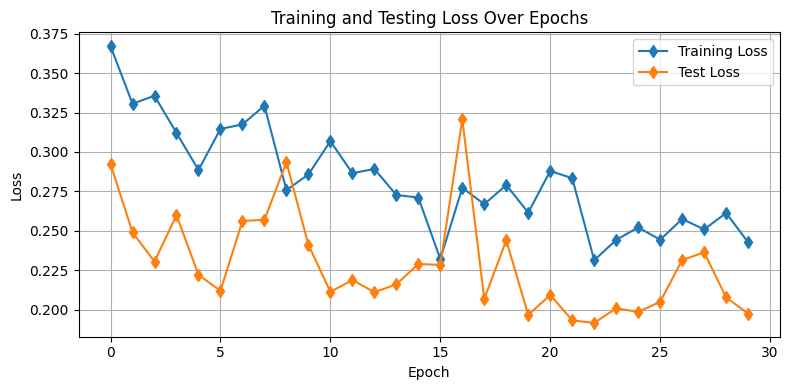

In [16]:
plot_losses(train_losses,test_losses)

We can also look visually at our demo examples to see how the model is doing. As above, let's put this into a function:

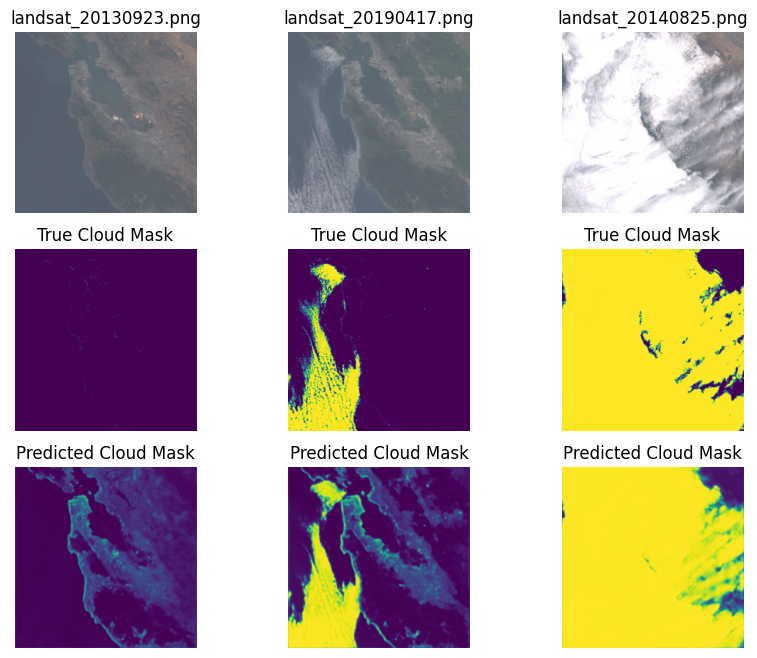

In [17]:
def plot_demo_image(model):

    # put the model in eval mode
    model.eval()
    
    # define the locations of the demo images and the corresponding masks
    demo_images_dir="Data/Demo/Images"
    demo_masks_dir="Data/Demo/Masks"
    
    # get the paths of the images
    img_names = ['landsat_20130923.png','landsat_20190417.png','landsat_20140825.png']
    
    fig = plt.figure(figsize=(10,8))
    
    for i, img_name in enumerate(img_names):
    
        img_path = os.path.join(demo_images_dir, img_name)
        msk_path = os.path.join(demo_masks_dir, img_name[:-4]+'_cloud_mask.png')
    
        img = Image.open(img_path).convert("RGB")
        msk = Image.open(msk_path).convert("L")

        # Convert to tensor like the dataset does
        img_tensor = TF.to_tensor(img) 
        img_tensor = img_tf(img_tensor).unsqueeze(0).to(device)
    
        with torch.no_grad():
            logits = model(img_tensor)
            logits = logits.cpu().numpy().squeeze()
            prob = 1/(1+np.exp(-logits))
    
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
    
        plt.subplot(3,3,i+4)
        plt.imshow(msk,vmin=0,vmax=255)
        plt.title('True Cloud Mask')
        plt.axis('off')
        
        plt.subplot(3,3,i+7)
        plt.imshow(prob,vmin=0,vmax=1)
        plt.title('Predicted Cloud Mask')
        plt.axis('off')
    plt.show()

plot_demo_image(model)

Looking at the plot above, we can see that the model is doing a pretty good job. It's picking out the right features that pertain to clouds, but its also picking up a lot of the area on land.

## Modifying the U-net architecture

There's a few things we can do to modify the `U-net` architecture including:
- modify the number of "levels" and their sizes
- implement a "dilation" in the bottleneck layer

Let's try these one-by-one to observe their influence on the model:

### Reducing the number of feature layers

In the example above, we used four layers of size `features=[64, 128, 256, 512]`. Let's remove one and reduce their sizes to see how the layers affect the output:

In [13]:
model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
# run the training
epochs = 30
train_losses, test_losses =\
    train(model, criterion, epochs, train_loader, test_loader, device)

NameError: name 'epochs' is not defined

Let's check out how the losses look:

In [ ]:
plot_losses(train_losses,test_losses)

Further, let's see how we're doing on our demo images

In [ ]:
plot_demo_image(model)

Above, we can see that the lower amount of features results in a more "blurry" result compared to the previous model. This is because the smaller scale features in the image are learned and passed on by larger kernels. Let's check out another option.

### Adding Dilation to the Bottleneck

The bottleneck of the Unet architecture is the section between the encoder and the decoder. A dilation will add in spaces to the convolutional kernel so that it can learn a broader range of features. We have already built in dilation to this model so let's implement it here.

In [20]:
model = UNet(in_channels=3, out_channels=1, dilation=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
# run the training
train_losses, test_losses =\
    train(model, criterion, epochs, train_loader, test_loader, device)

In [ ]:
plot_losses(train_losses,test_losses)

In [ ]:
plot_demo_image(model)

**Key Takeaways**

1. A U-net is a type of convolutional neural network architecture that has both encoding (or "down-sampling") and decoding (or "up-sampling") convolutional layer.
2. A U-net is designed to return the values of a matrix (i.e. an image) given those in another matrix (i.e. an image or set of images).
3. The different components of the the U-net architecture directly map onto the final output product.